In [48]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from speechpy.processing import cmvn 

In [72]:
SR = 44000
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 60
SILENCE = 0.0018
SAMPLE_LENGTH = 0.5 #s
SAMPLE_SIZE = int(np.ceil(SR*SAMPLE_LENGTH))
NOISE_RATIO = 0.25

LABELS = ["cough", "not"]

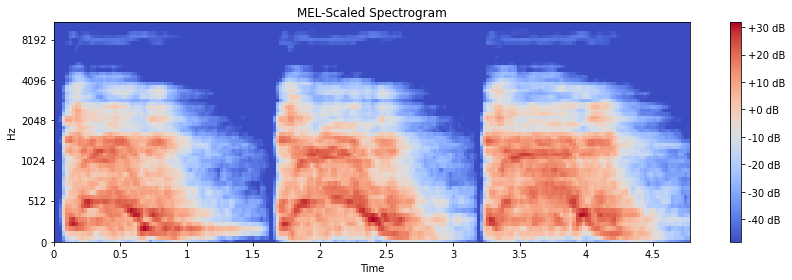

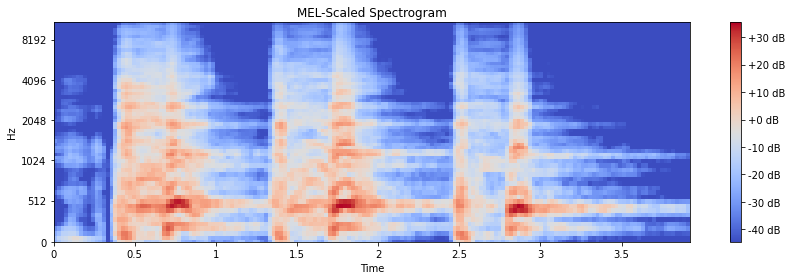

In [59]:
def envelope(signal, rate, thresh):
    mask = []
    y = pd.Series(signal).apply(np.abs)
    # Create aggregated mean
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for m in y_mean:
        mask.append(m > thresh)

    return mask

def load_audio(path):
    signal, rate = librosa.load(path, sr=SR)
    mask = envelope(signal, rate, SILENCE)
    signal = signal[mask]
    
    return signal

def melspectrogram(signal):
    signal = librosa.util.normalize(signal)
    spectro = librosa.feature.melspectrogram(
        signal,
        sr=SR,
        n_mels=N_MELS,
        n_fft=N_FFT
    )
    spectro = librosa.power_to_db(spectro)
    spectro = spectro.astype(np.float32)
    return spectro

audios = [
    load_audio("test/cough/1586532810683_cough_suspect_f_49_57022fb6-10cc-4dce-91fd-88bc0559076e.wav"),
    load_audio("test/cough/1586538036621_cough_healthy_m_51_11e04705-602e-49be-8857-9e7d52dea3f5.wav")
]

mels = []

for a in audios:
    mel = melspectrogram(a)
    mels.append(mel)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB');
    plt.title('MEL-Scaled Spectrogram')
    plt.tight_layout()
    plt.show()

In [64]:
AUGMENT = "noise/"
noises = []

for audio in os.listdir(AUGMENT):
    if os.path.splitext(audio)[-1] != ".wav":
        continue
    
    noises.append(AUGMENT+audio)        

In [77]:
def load_noises(n=2):
    ns = []
    ids = []
    for _ in range(n):
        while True:
            i = np.random.choice(len(noises))
            if i in ids:
                continue
            ids.append(i)
            noise, _ = librosa.load(noises[i], sr=SR)
            if len(noise) < SAMPLE_SIZE:
                continue
            ns.append(noise)
            break
    
    return ns

def augment(sample, ns):
    augmented = []
    for noise in ns:
        gap = len(noise)-len(sample)
        point = 0
        if gap > 0:
            point = np.random.randint(low=0, high=len(noise)-len(sample))
        noise = noise[point:point+len(sample)]
        final = []
        for f in range(len(sample)):
            n = noise[f]*NOISE_RATIO
            final.append(sample[f]+n)
        
        augmented.append(final)
    
    return augmented

def process(audio, aug=False):
    signal = load_audio(audio)
    
    if len(signal) < SAMPLE_SIZE:
        return []
    
    current = 0
    end = False
    features = []
    
    if aug:
        ns = load_noises()
        
    while not end:
        if current+SAMPLE_SIZE > len(signal):
            sample = signal[len(signal)-SAMPLE_SIZE:]
            end = True
        else:
            sample = signal[current:current+SAMPLE_SIZE]
            current += SAMPLE_SIZE
        
        features.append(melspectrogram(sample))
        
        if aug:
            signals = augment(sample, ns)
            for s in signals:
                features.append(melspectrogram(s))
    
    return features
                
def generate_dataset(folder, aug=False):
    data = [] #contains [mel, label]
    for i, label in enumerate(LABELS):
        print("Processing: "+label)
        for audio in tqdm(os.listdir(folder+label)):
            if os.path.splitext(audio)[-1] != ".wav":
                continue
            
            features = process(folder+label+"/"+audio, aug=aug and i == 0)
            for feat in features:
                data.append([feat, i])
    
    return data

In [78]:
DATA_FOLDER = "dataset/"
TEST_FOLDER = "test/"
EXTRA_FOLDER = "webapp/"

data = generate_dataset(DATA_FOLDER, True)
extra = generate_dataset(EXTRA_FOLDER)
data += extra
np.random.shuffle(data)
np.save("dataset.npy", data)

  0%|          | 0/36 [00:00<?, ?it/s]

Processing: cough


  0%|          | 0/2000 [00:00<?, ?it/s]

Processing: not


  0%|          | 0/72 [00:00<?, ?it/s]

Processing: cough


  0%|          | 0/31 [00:00<?, ?it/s]

Processing: not


100%|██████████| 31/31 [00:30<00:00,  1.03it/s]


Processing: cough


  0%|          | 0/11 [00:00<?, ?it/s]

Processing: not


100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


In [79]:
test = generate_dataset(TEST_FOLDER)
np.save("test.npy", test)

  0%|          | 0/34 [00:00<?, ?it/s]

Processing: cough


  0%|          | 0/17 [00:00<?, ?it/s]

Processing: not


100%|██████████| 17/17 [00:14<00:00,  1.14it/s]
